# Entrenamiento Modelos AA y AP (Pax Total): Comparativa

**Trabajo Fin de Máster**

**Sistema de predicción para prevenir la congestión en mostradores de facturación en aeropuertos**

Autor: David Cortés Alvarez

Máster en Inteligencia Artificial

## Librerías

In [1]:
# Tratamiento de Datos
# -----------------------------------------------------------------------------------
import numpy as np
import pandas as pd

In [2]:
# Gráficos
# -----------------------------------------------------------------------------------
import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from livelossplot import PlotLossesKeras

In [3]:
# Modelos
# -----------------------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

print("TensorFlow version: " + tf.__version__)
print("XgBoost version: " + xgb.__version__)

TensorFlow version: 2.7.0
XgBoost version: 1.5.0


In [4]:
# Varios
# -----------------------------------------------------------------------------------
#import random
#import time
#from math import sqrt
import pickle

## Definición de Funciones

In [5]:
def dataPrepocessing(dataset, aeropuertos, debug=False):
    if debug: print('Datos de entrada:')
    if debug: print("")
    if debug: print('Númmero de Filas y columnas:',dataset.shape)
    if debug: print(dataset.columns)
    if debug: print("")
    if debug: print(">> Se comienza el Data Pre-Processing...")
    
    # Eliminamos aquellos registros que no son de los aeropuertos a tratar
    dataset = dataset[dataset.APD.isin(aeropuertos)]
    if debug: print("Tarea 01: Registros de vuelos filtrados por aeropuertos --> OK")
    
    # Eliminamos los que no tienen oferta u ocupación
    dataset = dataset[(dataset['OFERTA'] > 0) & (dataset['OCUPACION'] > 0)]
    if debug: print("Tarea 02: Eliminar registros sin Oferta u Ocupación --> OK")
    
    # Convertimos el identificador de vuelo a número
    dataset['VUELO'] = dataset['VUELO'].astype('str')
    dataset['VUELO'] = dataset['VUELO'].str.replace(r'^(0+)(?!$)', '', regex=True).fillna('0')
    dataset['VUELO'] = dataset['VUELO'].astype(int)
    if debug: print("Tarea 03: Conversión del número de vuelo --> OK")
    
    # Creamos una columna nueva de los minutos del día que se produce la salida del vuelo. 
    dataset.insert(9, 'SALIDA_MINUTOS_DIA', 
                   dataset.HORA.astype(str).apply(lambda x: x.split(':'))
                   .apply(lambda x: int(x[0]) * 60 + int(x[1])))
    if debug: print("Tarea 04: Creación de la columna SALIDA_MINUTOS_DIA --> OK")

    # OUTLIERS: Filtramos los registros incongruentes
    dataset = dataset[dataset['OFERTA'] >= dataset['PAX_V']]
    dataset = dataset[dataset['OFERTA'] >= dataset['PAX']]
    dataset = dataset[dataset['OFERTA'] <= dataset['CMAX']]
    if debug: print("Tarea 05: Tratamiento Outliers --> OK")
    
    # NORMALIZACIÓN y ESCALADO
    # Insertamos una nueva columna FACTOR_OFERTA basado en OFERTA a un valor ponderable entre 0-1 
    #con respecto a CCMAX 
    dataset.insert(8, 'FACTOR_OFERTA', ((dataset['OFERTA'] * 100) / dataset['CMAX'])/100)
    # Transformamos OCUPACION por FACTOR_OCUPACION
    dataset.insert(9, 'FACTOR_OCUPACION', (dataset['OCUPACION'] / 100))
    if debug: print("Tarea 06: Normalización y Escalado --> OK")
    
    # TRATAMIENTO DE NULOS
    #Borramos aquellos registros que contienen nulos en PAX, PAX_M y PAX_V
    dataset = dataset.dropna(subset=['PAX_M'])
    dataset = dataset.dropna(subset=['PAX_V'])
    dataset = dataset.dropna(subset=['FACTOR_OFERTA'])
    dataset = dataset.dropna(subset=['CMAX'])
    if debug: print("Tarea 07: Tratamiento de nulos --> OK")
    
    # Convertir los valores categóricos en numéricos
    dataset = pd.get_dummies(dataset, columns = ['APD','APA','SEGMENTO', 'FLOTA',
                                                 'PROPIETARIO_VUELO','FRANJA_HORARIA','OPERADOR',
                                                 'SECTOR','MATR'])
    if debug: print("Tarea 08: Conversión datos categóricos --> OK")
    
    # Data Cleaning 
    dataset = dataset.drop(columns=['HORA'])       # Sustitución por SALIDA_MINUTOS_DIA
    dataset = dataset.drop(columns=['OFERTA'])     # Sustitución por FACTOR_OFERTA
    dataset = dataset.drop(columns=['OCUPACION'])  # Sustitución por FACTOR_OCUPACION
    # Características no usadas en la predicción:
    dataset = dataset.drop(columns=['ID_VUELO','DIA','ANIO','CIA','FECHA_SALIDA_PROG','PAX_V'])
    if debug: print("Tarea 09: Borrado de columnas --> OK")
    if debug: print("")    
    if debug: print(">> FIN ")
    if debug: print("")
    if debug: print('Datos de salida:')
    if debug: print("")
    if debug: print('Númmero de Filas y columnas:',dataset.shape)
    if debug: print(dataset.columns)
    if debug: print("")
    
    return dataset

In [6]:
def evaluateModel(y_true, y_pred):
    print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_true, y_pred, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
    print('Explained Variance Score             :', metrics.explained_variance_score(y_true, y_pred))
    print('Max Error                            :', metrics.max_error(y_true, y_pred))
    print('Median Absolute Error                :', metrics.median_absolute_error(y_true, y_pred))
    print('R^2                                  :', metrics.r2_score(y_true, y_pred))
    
    # Gráfica 
    plt.figure(figsize=(15,10))
    plt.scatter(y_true, y_pred, c='green')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', c='red', lw=3)
    plt.xlabel('Training Values')
    plt.ylabel('Predicted Values')
    plt.title('Training Vs Predicted')

In [7]:
def plot_history(history, key):
    plt.figure(figsize=(15,10))
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()

## Carga de Datos

In [8]:
# Parámetros de entrada
GridSearchCV_Active = False #Parámetro que activa el entrenamiento con búsqueda GridSearchCV
Escalas_Seleccionadas = ['LPA', 'ACE', 'FUE', 'TFN', 'TFS', 'SPC', 'VDE','GMZ']
NombreFichero = "TFM_FileIN_Dataset_Training.csv"

In [9]:
#from google.colab import files
#upload = files.upload()

In [10]:
data = pd.read_csv(NombreFichero, header=0, sep=',',encoding = "ISO-8859-1")

In [12]:
# Pre-Procesado de datos
data_model=dataPrepocessing(data,Escalas_Seleccionadas,debug=True)

Datos de entrada:

Númmero de Filas y columnas: (168156, 29)
Index(['ID_VUELO', 'APD', 'APA', 'SEGMENTO', 'CIA', 'VUELO', 'FLOTA',
       'PROPIETARIO_VUELO', 'FECHA_SALIDA_PROG', 'ANIO', 'MES', 'DIA',
       'DIA_SEMANA', 'HORA', 'FESTIVO', 'MATR', 'FRANJA_HORARIA', 'OPERADOR',
       'OFERTA', 'PAX', 'OCUPACION', 'SECTOR', 'CMAX', 'PAX_V', 'PAX_M',
       'A180', 'A120', 'A60', 'A0'],
      dtype='object')

>> Se comienza el Data Pre-Processing...
Tarea 01: Registros de vuelos filtrados por aeropuertos --> OK
Tarea 02: Eliminar registros sin Oferta u Ocupación --> OK
Tarea 03: Conversión del número de vuelo --> OK
Tarea 04: Creación de la columna SALIDA_MINUTOS_DIA --> OK
Tarea 05: Tratamiento Outliers --> OK
Tarea 06: Normalización y Escalado --> OK
Tarea 07: Tratamiento de nulos --> OK
Tarea 08: Conversión datos categóricos --> OK
Tarea 09: Borrado de columnas --> OK

>> FIN 

Datos de salida:

Númmero de Filas y columnas: (146377, 116)
Index(['VUELO', 'FACTOR_OFERTA', 'FACTOR_OCUP

**Ajustes Finales**

In [13]:
col_res = ['PAX_M','A180','A120','A60','A0']
colname_predict = 'PAX_M'

In [14]:
# División de los datos (Split)
X = data_model.drop(columns=col_res,axis=1).values
y = data_model[colname_predict]
#X_eval = data_model_evaluate.drop(columns=col_res,axis=1).values

In [15]:
# Hold-out validation

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(102463, 111)
(43914, 111)
(102463,)
(43914,)


## Linear Regression

In [16]:
# Training the Regression with GridSearchCV
if GridSearchCV_Active:
    lrm = LinearRegression()

    parameters = {
        'fit_intercept':[True,False], 
        'copy_X':[True, False]}
    grid = GridSearchCV(lrm, parameters, cv=5)
    grid.fit(X_train, y_train)

    print(grid.best_params_)
    print(grid.score(X_test, y_test))
else:
    print("GridSearchCV inactivo para LinearRegression.")

GridSearchCV inactivo para LinearRegression.


In [17]:
# Training the Regression
lrm = LinearRegression(
    fit_intercept=True,
    copy_X=True)
lrm.fit(X_train, y_train)

y_pred_lr = lrm.predict(X_test)

In [18]:
# Model Score
print("Test score: {0:.2f} %".format(100 * lrm.score(X_test, y_test)))

Test score: 62.73 %


Mean Absolute Error (MAE)            : 6.173330841365586
Mean Squared Error (MSE)             : 64.88894619524501
Root Mean Squared Error (RMSE)       : 8.05536753942643
Mean Absolute Percentage Error (MAPE): 0.296865613428406
Explained Variance Score             : 0.6273418070531802
Max Error                            : 50.37720693903299
Median Absolute Error                : 4.900836902382576
R^2                                  : 0.627341346861571


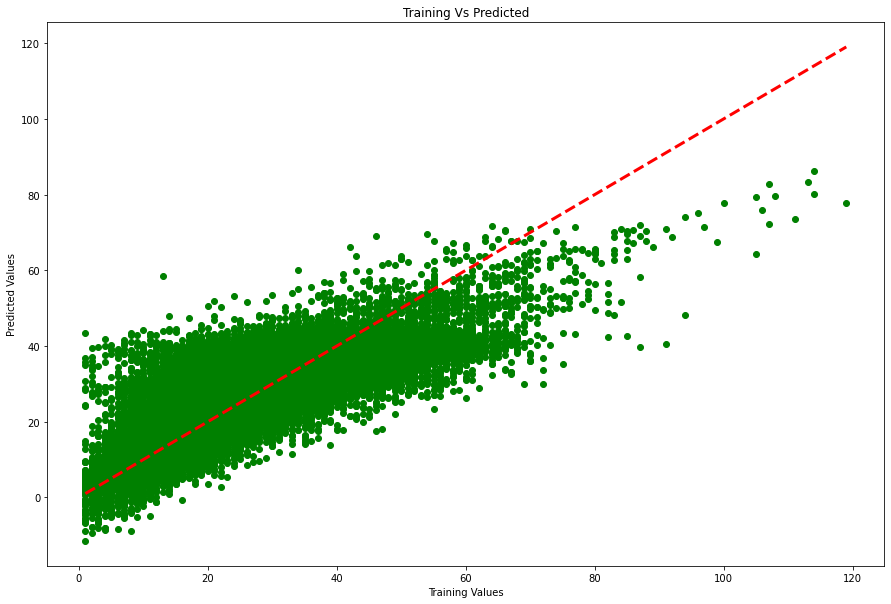

In [19]:
# Model Evaluation
evaluateModel(y_test, y_pred_lr)

## Random Forest Regression

In [20]:
# Training the Regression with GridSearchCV
if GridSearchCV_Active:
    rfm = RandomForestRegressor()

    parameters = {
        "n_estimators"      : [500],
        "max_features"      : ["auto"],
        "bootstrap"         : [True],
        "max_depth"         : [None],
        "min_samples_leaf"  : [1],
        "min_samples_split" : [5],
        "random_state"      : [10]
    }

    grid = GridSearchCV(rfm, parameters, cv=10)
    grid.fit(X_train, y_train)

    print(grid.best_params_)
    print(grid.score(X_test, y_test))
else:
    print("GridSearchCV inactivo para Random Forest Regression.")

GridSearchCV inactivo para Random Forest Regression.


In [21]:
rfm = RandomForestRegressor(
    n_estimators = 500, 
    max_features = "auto",
    bootstrap = True,
    max_depth = None,
    min_samples_leaf = 1,
    min_samples_split = 5,
    random_state=10,
    verbose=1)
rfm.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 11.0min finished


RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=10,
                      verbose=1)

In [22]:
# Predicción de los datos de test
y_pred_rf=rfm.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.1s finished


In [23]:
# Model Score
print("Test score: {0:.2f} %".format(100 * rfm.score(X_test, y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score: 71.31 %


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.8s finished


Mean Absolute Error (MAE)            : 5.282127275877955
Mean Squared Error (MSE)             : 49.951735074154875
Root Mean Squared Error (RMSE)       : 7.067654142228161
Mean Absolute Percentage Error (MAPE): 0.24029308994337895
Explained Variance Score             : 0.7131561310641713
Max Error                            : 47.91588542013541
Median Absolute Error                : 4.076137301587313
R^2                                  : 0.7131260806940602


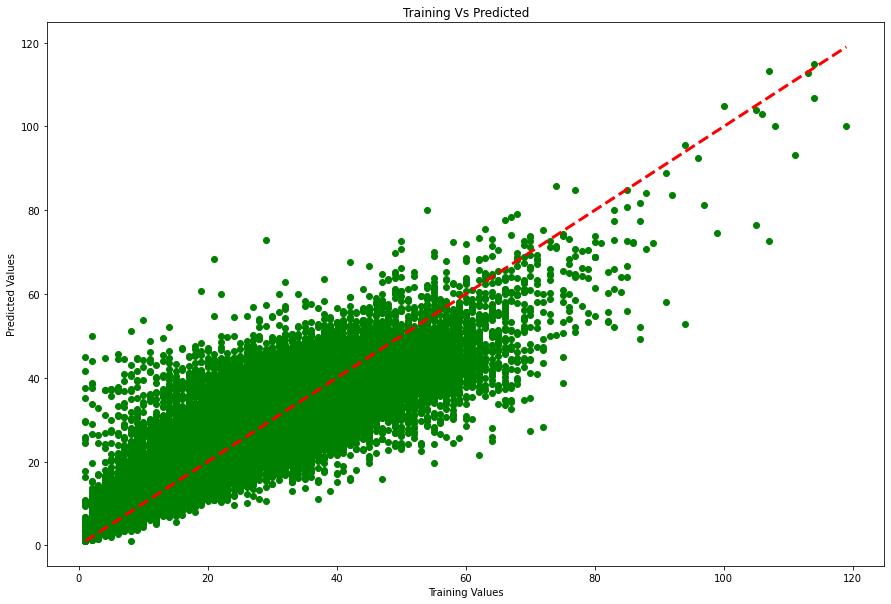

In [24]:
# Model Evaluation
evaluateModel(y_test,y_pred_rf)

Prueba para grabar, cargar y hacer predicción con el modelo de Random Forest: 

In [25]:
# Save the Modle to file in the current working directory
Pkl_Filename = "TFM_DCA_RFModel_PAX_M.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rfm, file)

In [26]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    ModeloRF = pickle.load(file)

ModeloRF

RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=10,
                      verbose=1)

In [27]:
# Model Score
print("Test score: {0:.2f} %".format(100 * ModeloRF.score(X_test, y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score: 71.31 %


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.5s finished


## XGBoost Regression

In [28]:
# Training the Regression with GridSearchCV
if GridSearchCV_Active:
    xgb_r = xgb.XGBRegressor()

    parameters = {
        'learning_rate':[0.1, 0.01, 0.001],
        'n_estimators': [100],
        'max_depth': [3,5,10],
        'subsample': [0.8, 0.9, 1],
        'colsample_bytree': [0.3, 0.5, 0.8, 0],
        'gamma': [0,1,5]

    }

    grid = GridSearchCV(xgb_r, parameters, cv=5, verbose=1)
    grid.fit(X_train, y_train)

    print(grid.best_params_)
    print(grid.score(X_test, y_test))
else:
    print("GridSearchCV inactivo para XGBoost Regression.")

GridSearchCV inactivo para XGBoost Regression.


In [29]:
xgb_r = xgb.XGBRegressor(
    n_estimators = 500, 
    colsample_bytree = 0.8,
    learning_rate = 0.1,
    max_depth = None,
    subsample = 0.9,
    random_state=10,
    silent=None,
    verbosity=1)
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=None,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=1)

In [30]:
# Predicción de los datos de test
y_pred_xgb = xgb_r.predict(X_test)

In [31]:
# Model Score
print("Test score: {0:.2f} %".format(100 * xgb_r.score(X_test, y_test)))

Test score: 73.14 %


Mean Absolute Error (MAE)            : 5.0981466491053595
Mean Squared Error (MSE)             : 46.76961710727132
Root Mean Squared Error (RMSE)       : 6.838831560089145
Mean Absolute Percentage Error (MAPE): 0.23366994751506034
Explained Variance Score             : 0.7314063728557281
Max Error                            : 49.13341522216797
Median Absolute Error                : 3.9062538146972656
R^2                                  : 0.7314010545563006


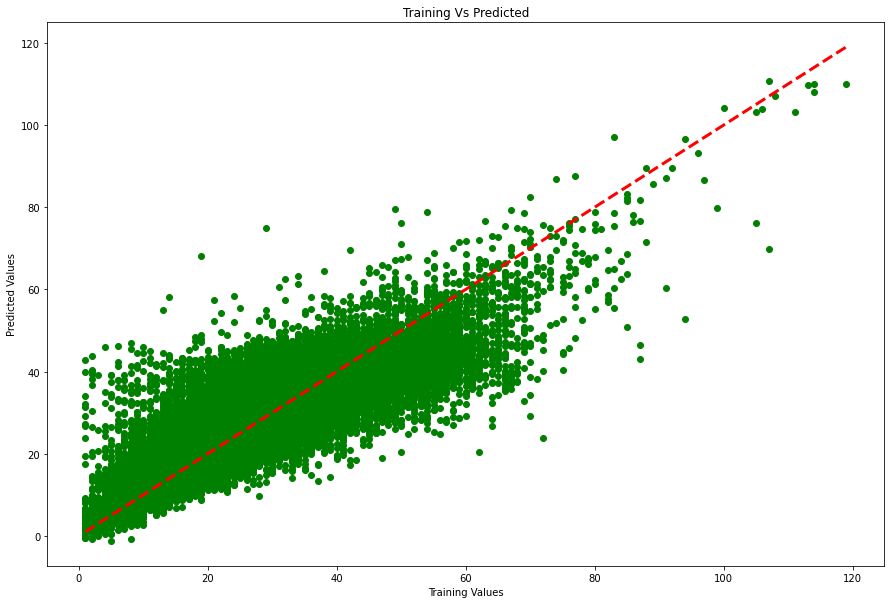

In [32]:
# Model Evaluation
evaluateModel(y_test,y_pred_xgb)

## Deep Learning Regression Model A

In [68]:
# Normalizamos los datos
ss =StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [69]:
# Construimos la red neuronal
NN_model_A = Sequential()

# The Input Layer :
NN_model_A.add(Dense(20, input_dim = X.shape[1]))

# The Output Layer :
NN_model_A.add(Dense(1))

NN_model_A.compile(loss='mae', 
                   metrics=['mse', 'mae'])

NN_model_A.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 20)                2240      
                                                                 
 dense_17 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


In [70]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

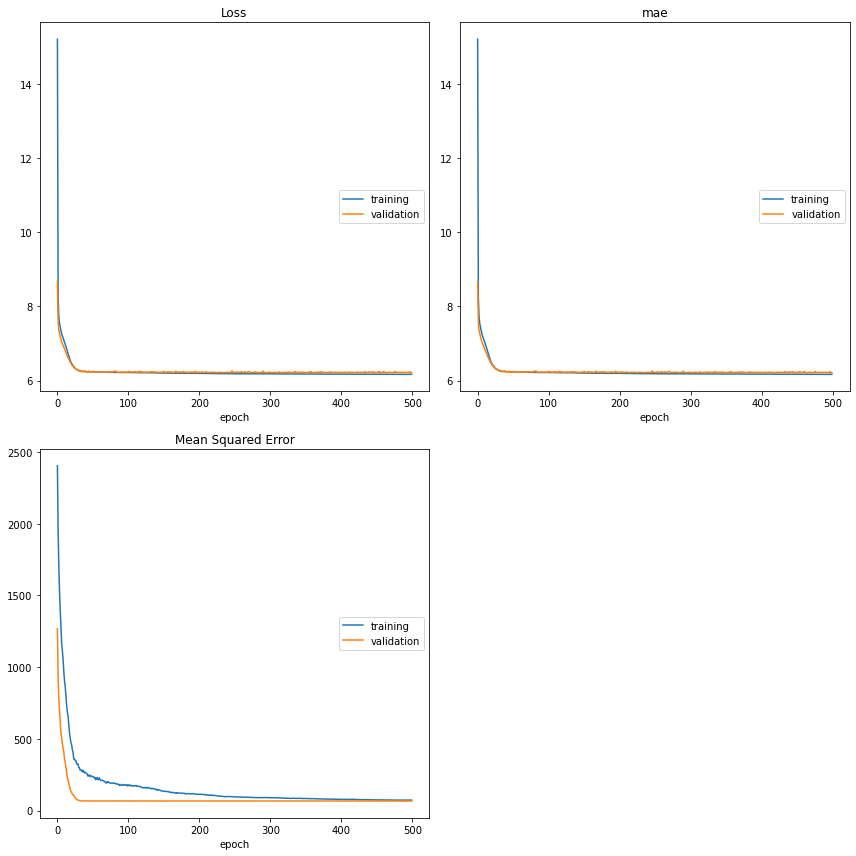

Loss
	training         	 (min:    6.166, max:   15.214, cur:    6.170)
	validation       	 (min:    6.209, max:    8.672, cur:    6.216)
mae
	training         	 (min:    6.166, max:   15.214, cur:    6.170)
	validation       	 (min:    6.209, max:    8.672, cur:    6.216)
Mean Squared Error
	training         	 (min:   71.771, max: 2403.959, cur:   72.854)
	validation       	 (min:   66.301, max: 1266.758, cur:   66.407)


In [71]:
history = NN_model_A.fit(
    X_train_scaled, y_train,
    epochs=500, 
    validation_split = 0.2, 
    verbose=0,
    callbacks=[PlotLossesKeras()])

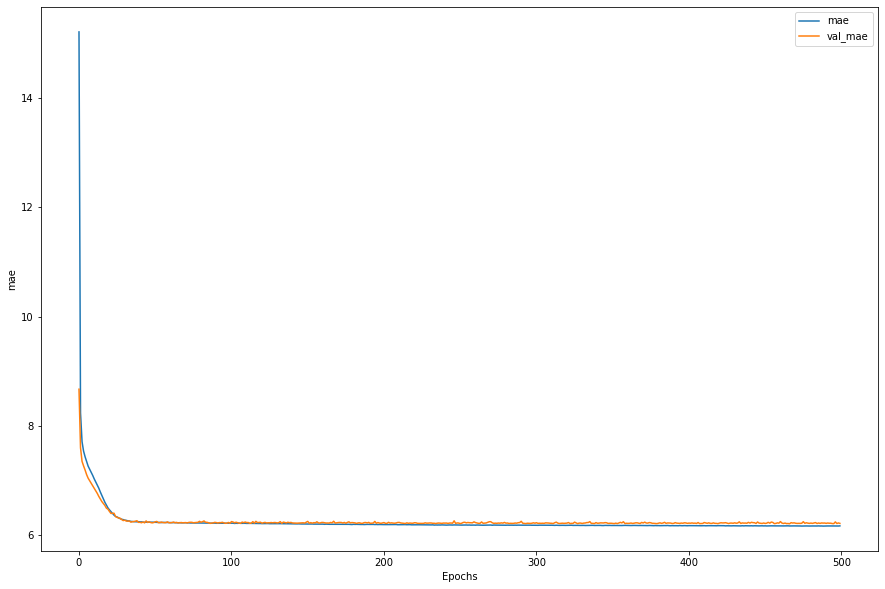

In [72]:
# Plot the history
plot_history(history, 'mae')

In [73]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
495,6.168513,72.578911,6.168513,6.211755,66.303741,6.211755,495
496,6.167829,72.484413,6.167829,6.242771,67.300880,6.242771,496
497,6.169142,71.821098,6.169142,6.213399,66.405716,6.213399,497
498,6.167842,73.097771,6.167842,6.223782,66.661690,6.223782,498
499,6.170146,72.853561,6.170146,6.215579,66.407265,6.215579,499


In [74]:
y_pred_nn = NN_model_A.predict(X_test_scaled)

Mean Absolute Error (MAE)            : 6.180943937940546
Mean Squared Error (MSE)             : 65.52891986090665
Root Mean Squared Error (RMSE)       : 8.094993505921215
Mean Absolute Percentage Error (MAPE): 0.2962062087821561
Explained Variance Score             : 0.623672621941865
Max Error                            : 49.700897216796875
Median Absolute Error                : 4.880420684814453
R^2                                  : 0.623665963945474


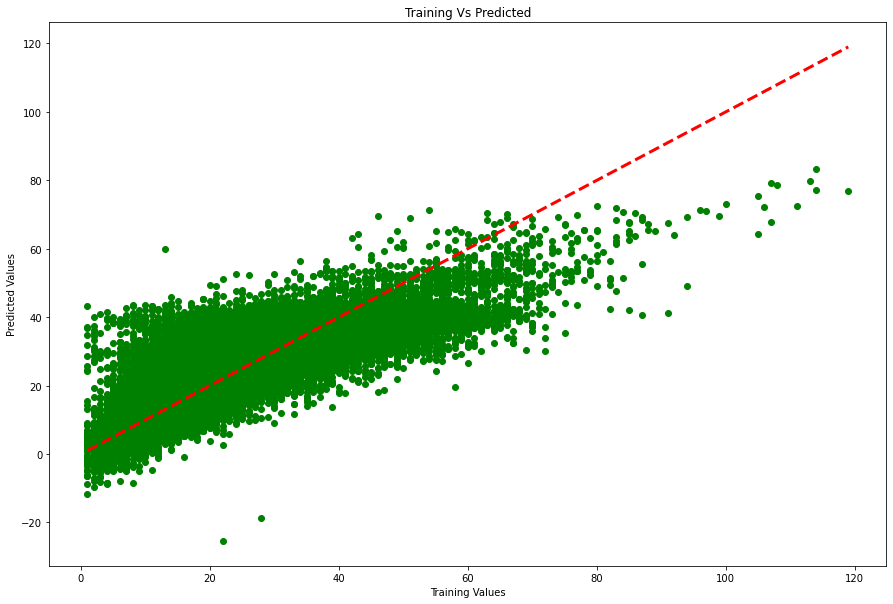

In [75]:
# Model Evaluation
evaluateModel(y_test,y_pred_nn)

## Deep Learning Regression Model B

In [62]:
# Normalizamos los datos
ss =StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [63]:
# Construimos la red neuronal
NN_model_B = Sequential()

# The Input Layer :
NN_model_B.add(Dense(128, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
#NN_model.add(Dropout(0.2))

# The Hidden Layers :
NN_model_B.add(Dense(256, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dropout(0.2))
NN_model_B.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model_B.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model_B.add(Dense(1, kernel_initializer='normal',activation='linear'))

#optimizer = tf.keras.optimizers.RMSprop(0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the network :
NN_model_B.compile(loss='mae', 
                 optimizer=optimizer, 
                 metrics=['mse','mae'])
NN_model_B.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               14336     
                                                                 
 dense_12 (Dense)            (None, 256)               33024     
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 179,201
Trainable params: 179,201
Non-trainable params: 0
_________________________________________________________________


In [64]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

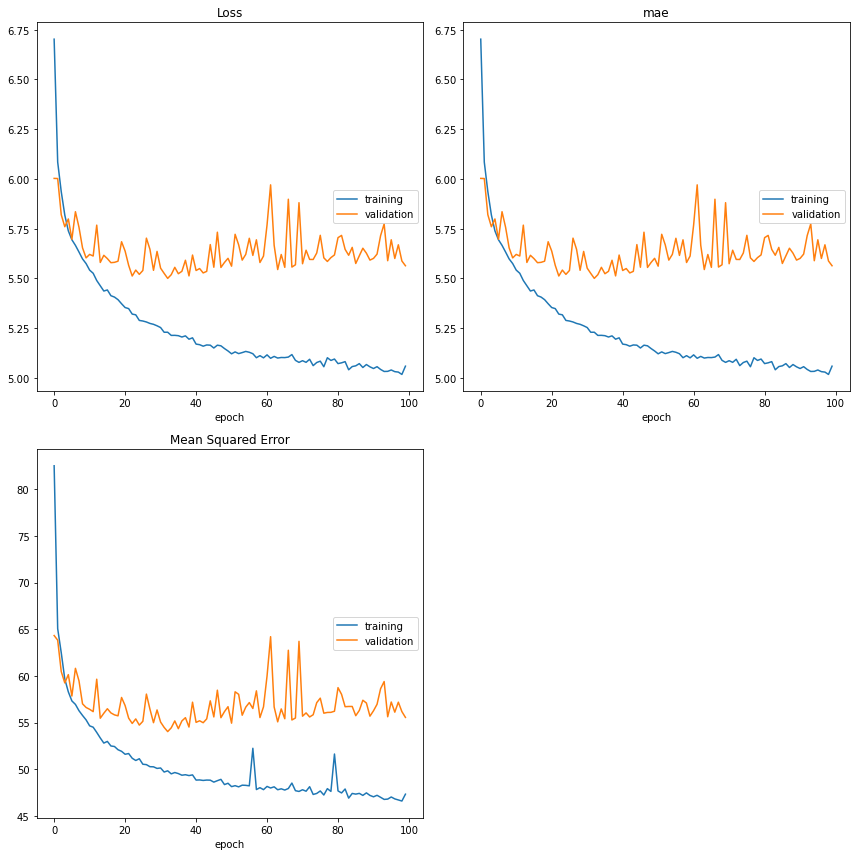

Loss
	training         	 (min:    5.018, max:    6.703, cur:    5.059)
	validation       	 (min:    5.501, max:    6.003, cur:    5.564)
mae
	training         	 (min:    5.018, max:    6.703, cur:    5.059)
	validation       	 (min:    5.501, max:    6.003, cur:    5.564)
Mean Squared Error
	training         	 (min:   46.587, max:   82.514, cur:   47.321)
	validation       	 (min:   54.028, max:   64.321, cur:   55.550)


In [65]:
history = NN_model_B.fit(
    X_train_scaled, y_train,
    epochs=100, 
    validation_split = 0.2, 
    verbose=0,
    callbacks=[PlotLossesKeras()])

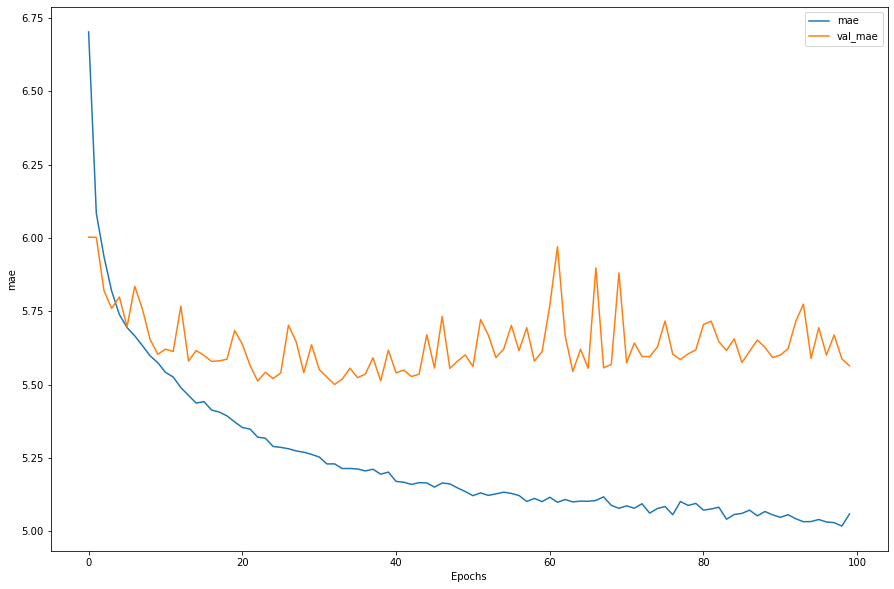

In [66]:
# Plot the history
plot_history(history, 'mae')

In [58]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
33,5.210939,49.404343,5.210939,5.531103,54.994003,5.531103,33
34,5.207757,49.396400,5.207757,5.539361,54.993706,5.539361,34
35,5.200881,49.475479,5.200881,5.862637,61.909378,5.862637,35
36,5.185607,49.104012,5.185607,5.584829,56.048870,5.584829,36
37,5.174352,48.995552,5.174352,5.533983,54.987659,5.533983,37


In [59]:
y_pred_nn = NN_model_B.predict(X_test_scaled)

Mean Absolute Error (MAE)            : 5.480594399381803
Mean Squared Error (MSE)             : 53.72424221580503
Root Mean Squared Error (RMSE)       : 7.329682272500291
Mean Absolute Percentage Error (MAPE): 0.24555500116581855
Explained Variance Score             : 0.6942267503463984
Max Error                            : 49.6275634765625
Median Absolute Error                : 4.230963230133057
R^2                                  : 0.6914604887435862


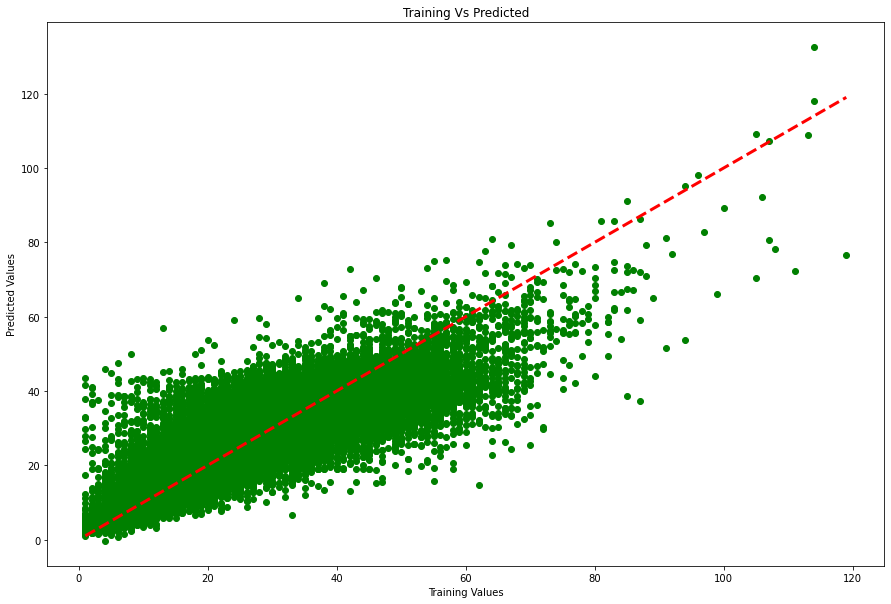

In [60]:
# Model Evaluation
evaluateModel(y_test,y_pred_nn)